# Testing tunability of models

In [36]:
# Packages
import copy

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.linear_model import ElasticNet
from timeit import default_timer as timer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Real, Integer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()

'c:\\Users\\jancw\\Desktop\\Studia\\Sem5\\AutoML\\Project_1'

In [7]:
# diabetes = pd.DataFrame(pd.read_csv("C:/Users/jancw/Desktop/Studia/Sem5/AutoML/Project_1/Datasets/diabetes.csv"))
diabetes = pd.DataFrame(pd.read_csv("./data/diabetes.csv"))
students = pd.DataFrame(pd.read_csv('./data/students.csv'))
# students = pd.DataFrame(pd.read_csv('C:/Users/jancw/Desktop/Studia/Sem5/AutoML/Project_1/Datasets/students.csv'))
students = students.loc[students.Target!='Enrolled']
# telco = pd.DataFrame(pd.read_csv('C:/Users/jancw/Desktop/Studia/Sem5/AutoML/Project_1/Datasets/telco.csv'))
telco = pd.DataFrame(pd.read_csv('./data/telco.csv'))
telco['TotalCharges'] = pd.to_numeric(telco['TotalCharges'],errors='coerce')
telco = telco.iloc[:,1:] # id column
# pistachio = pd.DataFrame(pd.read_csv('C:/Users/jancw/Desktop/Studia/Sem5/AutoML/Project_1/Datasets/pistachio.csv'))
pistachio = pd.DataFrame(pd.read_csv('./data/pistachio.csv'))
datasets = {'diabetes': diabetes,'students': students,'telco': telco,'pistachio': pistachio}

# Wybór danych i rekonesans

In [8]:
# datasets sizes
for key in datasets:
    print(f'{key} len: {len(datasets.get(key))}')

diabetes len: 100000
students len: 3630
telco len: 7043
pistachio len: 2148


In [9]:
# we need about 1500 rows from each set
random_seed = 24
datasets_wanted_size = {}
for key in datasets:
    dataset_size = len(datasets.get(key))
    X = datasets.get(key)
    y = datasets.get(key).iloc[:,-1]
    rest,data_wanted_size = train_test_split(X,test_size=1500/dataset_size,stratify=y,random_state=random_seed)
    datasets_wanted_size[key] = data_wanted_size

In [10]:
# typy kolumn
for key in datasets_wanted_size:
    print(key + ':')
    print(f'{datasets_wanted_size.get(key).dtypes.value_counts()}\n')

diabetes:
int64      4
float64    3
object     2
Name: count, dtype: int64

students:
int64      29
float64     5
object      1
Name: count, dtype: int64

telco:
object     16
int64       2
float64     2
Name: count, dtype: int64

pistachio:
float64    26
int64       2
object      1
Name: count, dtype: int64



In [11]:
# rozkład y
for key in datasets_wanted_size:
    print(key+':')
    print(f'{datasets_wanted_size.get(key).iloc[:,-1].value_counts()}\n')

# zmieniamy dla każdego zbioru ,y na wartości {0,1}
label_encoder = LabelEncoder()
for key in datasets_wanted_size:
    datasets_wanted_size[key].iloc[:,-1] = label_encoder.fit_transform(datasets_wanted_size[key].iloc[:,-1])
    datasets_wanted_size[key] = datasets_wanted_size[key].astype({datasets_wanted_size.get(key).columns[-1]: 'int64'})

diabetes:
diabetes
0    1373
1     127
Name: count, dtype: int64

students:
Target
Graduate    913
Dropout     587
Name: count, dtype: int64

telco:
Churn
No     1102
Yes     398
Name: count, dtype: int64

pistachio:
Class
Kirmizi_Pistachio    860
Siirt_Pistachio      640
Name: count, dtype: int64



Sprawdzanie wartości zmiennyck o typach 'object'

In [12]:
dataset = datasets_wanted_size.get('diabetes')
object_columns = dataset.select_dtypes(include='object')
object_columns_unique_values = {column: dataset[column].unique() for column in object_columns}

for key in object_columns_unique_values:
    print(f'{key}: {object_columns_unique_values.get(key)}')

dataset.head(3)

# nulls :
    # czy w gender: 'Other'==null
    # czy w smoking_history 'No info'==null

# object column encoding :
    # gender - 
    # smoking_history - 



gender: ['Male' 'Female']
smoking_history: ['former' 'never' 'ever' 'No Info' 'not current' 'current']


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
60094,Male,62.0,1,1,former,27.32,4.8,155,0
90264,Male,61.0,0,0,never,58.05,5.7,155,1
53832,Female,73.0,0,0,never,27.32,6.5,200,0


In [13]:
dataset = datasets_wanted_size.get('students')
object_columns = dataset.select_dtypes(include='object')
object_columns_unique_values = {column: dataset[column].unique() for column in object_columns}

for key in object_columns_unique_values:
    print(f'{key}: {object_columns_unique_values.get(key)}')

# kolumny są numeryczne

dataset.head(3)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
4310,1,15,1,6,1,14,1,23,27,10,...,1,6,12,6,13.625,0,12.4,0.5,1.79,1
4318,1,1,1,2,1,1,14,1,1,10,...,4,11,12,11,15.000,0,8.9,1.4,3.51,1
209,1,12,1,11,1,12,1,3,14,3,...,0,6,6,5,12.800,0,16.2,0.3,-0.92,0


In [14]:
dataset = datasets_wanted_size.get('telco')
object_columns = dataset.select_dtypes(include='object')
object_columns_unique_values = {column: dataset[column].unique() for column in object_columns}

for key in object_columns_unique_values:
    print(f'{key}: {object_columns_unique_values.get(key)}')
    
dataset.head(3)

# object column encoding :
    # wszytkie kolumny wartościach binarnych - label encoding
    # Contract - 
    # TotalCharges - zmiana typu na float, (są wartości ' ' ,które mogą być traktowane jako null)
    # pozostałe - one-hot encoding

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['Yes' 'No' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['Yes' 'No' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['Yes' 'No' 'No internet service']
Contract: ['Two year' 'Month-to-month' 'One year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4726,Female,0,Yes,No,72,No,No phone service,DSL,Yes,Yes,Yes,No,No,Yes,Two year,Yes,Electronic check,49.20,3580.95,0
5892,Male,0,No,No,10,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,51.65,524.50,0
274,Male,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Mailed check,70.60,70.60,1


In [15]:
dataset = datasets_wanted_size.get('pistachio')
object_columns = dataset.select_dtypes(include='object')
object_columns_unique_values = {column: dataset[column].unique() for column in object_columns}

for key in object_columns_unique_values:
    print(f'{key}: {object_columns_unique_values.get(key)}')

# kolumny są numeryczne

dataset.head(3)

,Area,Perimeter,Major_Axis,Minor_Axis,Eccentricity,Eqdiasq,Solidity,Convex_Area,Extent,Aspect_Ratio,...,StdDev_RR,StdDev_RG,StdDev_RB,Skew_RR,Skew_RG,Skew_RB,Kurtosis_RR,Kurtosis_RG,Kurtosis_RB,Class
1682,80139,1075.2321,418.1198,244.6082,0.8110,319.4310,0.9928,80719,0.7494,1.7093,...,14.5330,15.2768,14.2298,-0.7579,-0.6986,-0.3487,3.4817,3.2926,2.6470,1
89,85969,2345.6279,421.6958,291.1149,0.7235,330.8461,0.8702,98789,0.7033,1.4486,...,18.2206,18.1049,16.7189,-0.9762,-0.9983,-0.7881,3.1975,3.3114,3.3104,0
2021,95334,1251.7111,488.1582,249.2888,0.8598,348.4007,0.9858,96705,0.7721,1.9582,...,23.4085,24.2855,22.0737,-0.6492,-0.4470,-0.4217,2.6227,2.3029,2.2124,1


# Preprocessing

- jeżeli kolumna ma 2 wartości to label encoding, wpp one-hot encoding ,(może coś innego pomyśleć) - wzialem dummy onehotencoder do pipeline
- 

In [13]:
# notatnik
# diabetes.nunique()==2

# pip_num = Pipeline(steps=[('impute',SimpleImputer()),
#                           ('scale',MinMaxScaler())])
# pip_cat = Pipeline(steps=[
#     ('ohe',OneHotEncoder()),
#     ('impute',SimpleImputer())])

# col_trans = ColumnTransformer([
#     ("numeric",pip_num,make_column_selector(dtype_include= np.number)),
#     ("cat",pip_cat,make_column_selector(dtype_include= np.object_))
# ])

# model_pipeline = Pipeline([("trans",col_trans),("model",RandomForestClassifier())])
# model_pipeline.fit(datasets_X_test.get('telco'),np.array(datasets_y_test.get('telco')))

# Modele

In [ ]:
# 1 - DecisionTreeClassifier

# class sklearn.tree.DecisionTreeClassifier(*, 
#                                         criterion='gini',
#                                         splitter='best',
#                                         max_depth=[],
#                                         min_samples_split=2, 
#                                         min_samples_leaf=1, 
#                                         min_weight_fraction_leaf=0.0, 
#                                         max_features=None, 
#                                         random_state=None, 
#                                         max_leaf_nodes=None, 
#                                         min_impurity_decrease=0.0, 
#                                         class_weight=None, 
#                                         ccp_alpha=0.0, 
#                                         monotonic_cst=None)


In [16]:
# 2 - LogisticRegression

# class sklearn.linear_model.LogisticRegression(penalty='l2', 
#                                               *, 
#                                               dual=False, 
#                                               tol=0.0001, 
#                                               C=1.0, 
#                                               fit_intercept=True, 
#                                               intercept_scaling=1, 
#                                               class_weight=None, 
#                                               random_state=None, 
#                                               solver='lbfgs', 
#                                               max_iter=100, 
#                                               multi_class='deprecated', 
#                                               verbose=0, 
#                                               warm_start=False, 
#                                               n_jobs=None, 
#                                               l1_ratio=None)

In [17]:
# 3 - GradientBoostingClassifier

# class sklearn.ensemble.GradientBoostingClassifier(*, 
#                                                   loss='log_loss', 
#                                                   learning_rate=0.1, 
#                                                   n_estimators=100, 
#                                                   subsample=1.0, 
#                                                   criterion='friedman_mse', 
#                                                   min_samples_split=2, 
#                                                   min_samples_leaf=1, 
#                                                   min_weight_fraction_leaf=0.0, 
#                                                   max_depth=3, 
#                                                   min_impurity_decrease=0.0, 
#                                                   init=None, random_state=None, 
#                                                   max_features=None, 
#                                                   verbose=0, 
#                                                   max_leaf_nodes=None, 
#                                                   warm_start=False, 
#                                                   validation_fraction=0.1, 
#                                                   n_iter_no_change=None, 
#                                                   tol=0.0001, 
#                                                   ccp_alpha=0.0)

In [16]:
# Import the required classifiers from scikit-learn

# Create objects of the classifiers
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()
ada_boost = AdaBoostClassifier()
bagging_classifier = BaggingClassifier()
k_neighbors = KNeighborsClassifier()
support_vector_machine = SVC()

# Display the classifier objects
classifiers = {
    "Logistic Regression": logistic_regression,
    "Decision Tree": decision_tree,
    "Random Forest": random_forest,
    "Gradient Boosting": gradient_boosting,
    "AdaBoost": ada_boost,
    "Bagging Classifier": bagging_classifier,
    "K-Neighbors": k_neighbors,
    "Support Vector Machine": support_vector_machine
}

In [17]:
random_seed = 24
datasets_X_train = {}
datasets_X_test = {}
datasets_y_train = {}
datasets_y_test = {}
for key in datasets_wanted_size:
    dataset_size = len(datasets_wanted_size.get(key))
    X = datasets_wanted_size.get(key).iloc[:,:-1]
    y = datasets_wanted_size.get(key).iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=random_seed)
    datasets_X_train[key] = X_train
    datasets_X_test[key] = X_test
    datasets_y_train[key] = y_train
    datasets_y_test[key] = y_test

In [22]:

tabela_wyników = {}

pip_num = Pipeline(steps=[('impute',SimpleImputer()),
                          ('scale',MinMaxScaler())])
pip_cat = Pipeline(steps=[
    ('ohe',OneHotEncoder(drop='first')),
    ('impute',SimpleImputer())])
col_trans = ColumnTransformer([
    ("numeric",pip_num,make_column_selector(dtype_include= np.number)),
    ("cat",pip_cat,make_column_selector(dtype_include= np.object_))
])


example_pipeline = Pipeline([("trans",col_trans),("model",RandomForestClassifier())])
example_pipeline.fit(datasets_X_test.get('telco'),np.array(datasets_y_test.get('telco')))



Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002132D2E6B10>),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first')),
                                                                  ('impute',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002132D2E6270>)])),
                ('model', RandomForestClassifier())])

In [ ]:
set_key = 'students'

for key in classifiers:
    start = timer()
    model_pipeline = Pipeline([("trans",col_trans),("model",classifiers[key])])
    model_pipeline.fit(datasets_X_train.get(set_key),datasets_y_train.get(set_key))    
    end = timer()
    y_hat = model_pipeline.predict(datasets_X_test.get(set_key))
    tabela_wyników[key] = [accuracy_score(y_hat,datasets_y_test.get(set_key)),end-start] #== [accuracy, time]


# pistachio
# {'Logistic Regression': [0.8766666666666667, 0.014618600020185113],
#  'Decision Tree': [0.8066666666666666, 0.02735049999319017],
#  'Random Forest': [0.8533333333333334, 0.3635247000493109],
#  'Gradient Boosting': [0.8666666666666667, 0.9874855000525713],
#  'AdaBoost': [0.8933333333333333, 0.2399780999403447],
#  'Bagging Classifier': [0.8466666666666667, 0.16180030000396073],
#  'K-Neighbors': [0.8766666666666667, 0.004990700050257146],
#  'Support Vector Machine': [0.89, 0.021320700063370168]}

# diabetes
# {'Logistic Regression': [0.96, 0.02030680002644658],
#  'Decision Tree': [0.94, 0.007484599947929382],
#  'Random Forest': [0.98, 0.11521570000331849],
#  'Gradient Boosting': [0.97, 0.14825059997383505],
#  'AdaBoost': [0.97, 0.078939100028947],
#  'Bagging Classifier': [0.97, 0.02978769992478192],
#  'K-Neighbors': [0.9266666666666666, 0.00779770000372082],
#  'Support Vector Machine': [0.96, 0.011258100043050945]}

# telco
# {'Logistic Regression': [0.8033333333333333, 0.024130700039677322],
#  'Decision Tree': [0.7566666666666667, 0.015992800006642938],
#  'Random Forest': [0.8, 0.15928849996998906],
#  'Gradient Boosting': [0.7966666666666666, 0.24993829999584705],
#  'AdaBoost': [0.8066666666666666, 0.10428309999406338],
#  'Bagging Classifier': [0.7833333333333333, 0.04923330002930015],
#  'K-Neighbors': [0.75, 0.011039600009098649],
#  'Support Vector Machine': [0.81, 0.028400499955751002]}

# students 
# {'Logistic Regression': [0.9066666666666666, 0.011891300091519952],
#  'Decision Tree': [0.8666666666666667, 0.01138309994712472],
#  'Random Forest': [0.9166666666666666, 0.1611720999935642],
#  'Gradient Boosting': [0.9233333333333333, 0.2623509999830276],
#  'AdaBoost': [0.9133333333333333, 0.12784590001683682],
#  'Bagging Classifier': [0.8966666666666666, 0.054303099983371794],
#  'K-Neighbors': [0.8233333333333334, 0.00486270000692457],
#  'Support Vector Machine': [0.8833333333333333, 0.0196890999795869]}


In [21]:
tabela_wyników

{'Logistic Regression': [0.9066666666666666, 0.016913700033910573],
 'Decision Tree': [0.87, 0.01254030002746731],
 'Random Forest': [0.9266666666666666, 0.15005080006085336],
 'Gradient Boosting': [0.9266666666666666, 0.2406470999121666],
 'AdaBoost': [0.9133333333333333, 0.0902577000670135],
 'Bagging Classifier': [0.9066666666666666, 0.055144599988125265],
 'K-Neighbors': [0.8233333333333334, 0.004798400099389255],
 'Support Vector Machine': [0.8833333333333333, 0.031351299956440926]}

# Wybrane modele

In [186]:

models = {
    # 'Elastic Net' : ElasticNet,
    # "KNN" : KNeighborsClassifier,
    'Decision Tree' : DecisionTreeClassifier,
    'Random Forest' : RandomForestClassifier,
    'Logistic Regression' : LogisticRegression
}

# Random Search

In [187]:
seed = 42
random.seed(seed)
np.random.seed(seed)
n_iter = 200


param_distributions = {
    'Logistic Regression': {
        'C': uniform(0.01, 100),  # Regularization strength
        'penalty': ['l1', 'l2'],   # Type of regularization
        'solver': ['liblinear'],   # solvers that support 'l1' and 'l2'
    },
    'Decision Tree': { 
        'ccp_alpha': uniform(0, 1), 
        'max_depth': randint(1, 31),
        'min_samples_leaf': randint(1, 61),  
        'min_samples_split': randint(2, 61), 
    },
    # 'kknn': {  
    #     'n_neighbors': randint(1, 31),
    # },
    # 'svm': { 
    #     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #     'C': uniform(2**-10, 2**10),
    #     'gamma': uniform(2**-10, 2**10),
    #     'degree': randint(2, 6),
    # },
    'Random Forest': {  
        'n_estimators': randint(1, 2001),
        # 'bootstrap': [True, False], 
        'max_samples': uniform(0.1, 0.1),
        'max_features': uniform(0, 1),  
        'min_samples_leaf': randint(1, 31), 
    }
    # 'xgboost': {
    #     'n_estimators': randint(1, 5001), 
    #     'learning_rate': uniform(2**-10, 1), 
    #     'subsample': uniform(0.1, 0.9),
    #     'booster': ['gbtree', 'gblinear', 'dart'],
    #     'max_depth': randint(1, 16),
    #     'min_child_weight': uniform(2**0, 2**7),
    #     'colsample_bytree': uniform(0, 1),
    #     'colsample_bylevel': uniform(0, 1),
    #     'reg_lambda': uniform(2**-10, 2**10),
    #     'reg_alpha': uniform(2**-10, 2**10),
    # }
}


param_samples = {
    alg: list(ParameterSampler(param_distributions[alg], n_iter=n_iter, random_state=seed))
    for alg in param_distributions
}
for alg, samples in param_samples.items():
    print(f"{alg} samples:")
    for i, sample in enumerate(samples):
        print(f"  Sample {i+1}: {sample}")


Logistic Regression samples:
  Sample 1: {'C': 37.464011884736244, 'penalty': 'l1', 'solver': 'liblinear'}
  Sample 2: {'C': 18.35347898661638, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 3: {'C': 59.87584841970366, 'penalty': 'l1', 'solver': 'liblinear'}
  Sample 4: {'C': 44.59327528535911, 'penalty': 'l1', 'solver': 'liblinear'}
  Sample 5: {'C': 5.818361216819946, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 6: {'C': 33.380861113902185, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 7: {'C': 70.81725777960456, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 8: {'C': 5.651157902710025, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 9: {'C': 83.25426408004218, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 10: {'C': 0.08787658410143283, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 11: {'C': 18.350450985343382, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 12: {'C': 61.17531604882809, 'penalty': 'l1', 'solver': 'liblinear'}
  Sample 13: {'C': 43.20450186421157, '

In [188]:
best_random = {
    'Random Forest': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Decision Tree': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Logistic Regression' : {'diabetes': None,'students': None,'telco': None,'pistachio': None}
}

best_random_history = {
    'Random Forest': {'diabetes': [],'students': [],'telco': [],'pistachio':  []},
    'Decision Tree': {'diabetes': [],'students': [],'telco': [],'pistachio': []},
    'Logistic Regression' : {'diabetes': [],'students': [],'telco': [],'pistachio': []}
}

best_random_history_params = {
    'Random Forest': {'diabetes': [],'students': [],'telco': [],'pistachio':  []},
    'Decision Tree': {'diabetes': [],'students': [],'telco': [],'pistachio': []},
    'Logistic Regression' : {'diabetes': [],'students': [],'telco': [],'pistachio': []}
}


In [189]:
optimization_metric = roc_auc_score
j=0
def optimize(model, param_samples):
    i = 0
    for dataset in datasets_wanted_size.keys():
        best_score = float('-inf')
        best_params = []
        for params in param_samples:
            
            estimator = models[model]()
            estimator.set_params(**params)
            pipe = Pipeline([("trans",col_trans),("model",estimator)])
            scores = cross_val_score(Pipeline([("trans",col_trans),("model",models[model]().set_params(**params))]), datasets_X_train[dataset], datasets_y_train[dataset], cv=3, scoring='roc_auc')  

            mean_score = scores.mean()
            std_score = scores.std()
            # estimator.fit(datasets_X_train[dataset], datasets_y_train[dataset]
            # y_pred = estimator.predict(datasets_X_test[dataset])
            # score = optimization_metric(datasets_y_test[dataset], y_pred)
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
                best_random[model][dataset] = Pipeline([("trans",copy.deepcopy(col_trans)),("model",models[model]().set_params(**params))])
                best_random[model][dataset].fit(datasets_X_train[dataset], datasets_y_train[dataset])
            best_random_history[model][dataset].append(best_score)
            best_random_history_params[model][dataset].append(best_params)
            i+=1
            print(i,j)
    
            

In [190]:
for model in models.keys():
    optimize(model, param_samples[model])
    j+=1

print(best_random)
print(best_random_history)
# optimize('Random Forest', param_samples['Random Forest'])

1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 0
184 0
185 

In [194]:
best_random_200iter_archive_v1 = best_random.copy()
best_random_history_200iter_archive_v1 = best_random_history.copy()
best_random_history_params_200iter_archive_v1 = best_random_history_params.copy()

In [179]:
# ile iteracji każdej metody potrzebujemy żeby uzyskać stabilne wyniki optymalizacji
def best_metric_so_far(model):
    kolory = {
        'diabetes': 'red',
        'students': 'green',
        'telco': 'blue',
        'pistachio': 'purple'
    }
    for key  in best_random_history[model].keys():
        plt.plot(best_random_history[model][key],label = key,c = kolory[key])
    plt.legend()
    plt.title(f'{model}: best roc_auc_score')
    # plt.xticks([i for i in range(n_iter)], labels=[i+1 for i in range(n_iter)])
    plt.show()
    return

def chart_1():
    for i,key  in enumerate(best_random_history.keys()):
        # print(i,key)
        plt.subplot(3, 1, i+1)
        best_metric_so_far(key)
    return

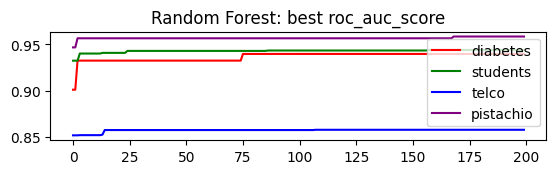

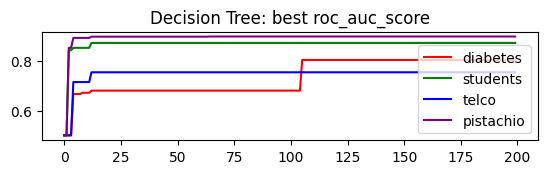

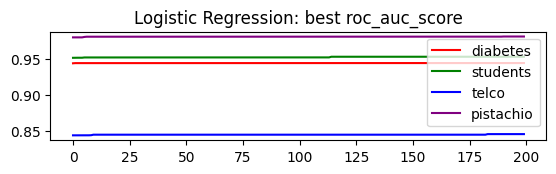

In [191]:
# best_metric_so_far('Random Forest')
chart_1()

# Bayes Search

In [ ]:
best_bayes = {
    'Random Forest': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Decision Tree': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Logistic Regression' : {'diabetes': None,'students': None,'telco': None,'pistachio': None}
}

best_bayes_score_history = {
    'Random Forest': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Decision Tree': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Logistic Regression' : {'diabetes': None,'students': None,'telco': None,'pistachio': None}
}

In [226]:

param_space_bayes = {
    'Logistic Regression': {
        'model__C': Real(0.01, 100.0, prior='uniform'),  
        'model__penalty': ['l1', 'l2'],                  
        'model__solver': ['liblinear'],                  
    },
    'Decision Tree': { 
        'model__ccp_alpha': Real(0.0, 1.0, prior='uniform'), 
        'model__max_depth': Integer(1, 30),                  
        'model__min_samples_leaf': Integer(1, 60),           
        'model__min_samples_split': Integer(2, 60),           
    },
    'Random Forest': {  
        'model__n_estimators': Integer(1, 2000),              
        'model__max_samples': Real(0.1, 1.0, prior='uniform'), 
        'model__max_features': Real(0.0, 1.0, prior='uniform'),
        'model__min_samples_leaf': Integer(1, 30),            
    }
}



# clas_model = LogisticRegression(max_iter=5000)
# search_space =
#   [
#    {
#     "solver": Categorical(['liblinear']),
#     "penalty": Categorical(['l1', 'l2']),
#     "fit_intercept": Categorical([True, False]),
#     #"warm_start": Categorical([True, False])
#    },
#    {
#     "solver": Categorical(['lbfgs', 'newton-cg', 'sag']),
#     "penalty": Categorical(['l2', 'none']),
#     "fit_intercept": Categorical([True, False]),
#     #"warm_start": Categorical([True, False])
#    },
#    {
#     "solver": Categorical(['saga']),
#     "penalty": Categorical(['l1', 'l2', 'none']),
#     "fit_intercept": Categorical([True, False]),
#     #"warm_start": Categorical([True, False])
#    },
#    {
#     "solver": Categorical(['saga']),
#     "penalty": Categorical(['elasticnet']),
#     "fit_intercept": Categorical([True, False]),
#     "l1_ratio": Real(0, 1, prior='uniform'),
#     #"warm_start": Categorical([True, False])
#    },
#   ]
# bayes_search = BayesSearchCV(clas_model, search_space, n_iter=12, scoring="accuracy", n_jobs=-1, cv=5)


In [228]:
scoring_metric = roc_auc_score

def bayes_optimize(model,param_space):
    for dataset in datasets_wanted_size.keys():
        opt = BayesSearchCV(
        Pipeline([("trans",col_trans),("model",models[model]())]),
        param_space,
        n_iter=50, 
        cv=2,       
        n_jobs=-1,  
        scoring=make_scorer(scoring_metric, needs_proba=True)
        )

        opt.fit(datasets_X_train[dataset],datasets_y_train[dataset])
        
        best_bayes[model][dataset] = opt.best_estimator_
        best_bayes_score_history[model][dataset] = opt.cv_results_['mean_test_score']


In [ ]:
for model in models:
    bayes_optimize(model, param_space_bayes[model])

# Model tunability

In [195]:
from sklearn.metrics import log_loss

criterion = roc_auc_score

best_scores_random = {}
deafult_scores = {}
tunability_random = {}

In [196]:
# loss dla najepszych modeli

for model in models.keys():
    best_scores_random[model] = {}
    for dataset in datasets_wanted_size.keys():
        best_scores_random[model][dataset] =  criterion(
            datasets_y_test[dataset],
            best_random[model][dataset].predict(datasets_X_test[dataset])
            )

print(best_scores_random['Decision Tree'])

{'diabetes': 0.88, 'students': 0.8670309653916211, 'telco': 0.66875, 'pistachio': 0.8264898255813953}


In [197]:
# loss dla deafult modeli

for model in models.keys():
    deafult_model = Pipeline([("trans",col_trans),("model",models[model]())])
    deafult_scores[model] = {}
    for dataset in datasets_wanted_size.keys():
        deafult_model.fit(datasets_X_train[dataset] , datasets_y_train[dataset])
        deafult_scores[model][dataset] =  criterion(datasets_y_test[dataset] , deafult_model.predict(datasets_X_test[dataset]))

print(deafult_scores['Decision Tree'])


{'diabetes': 0.8818181818181818, 'students': 0.8809023399187335, 'telco': 0.696590909090909, 'pistachio': 0.7965116279069767}


In [198]:
# Tunability dla poszczególnych datasetów
# Łączna dla modelu to średnia? idk trzeba bedzie dopytac


for model in models.keys():
    tunability_random[model] = {}
    for dataset in datasets_wanted_size.keys():
        tunability_random[model][dataset] = deafult_scores[model][dataset] - best_scores_random[model][dataset]

print(tunability_random['Decision Tree'])

{'diabetes': 0.0018181818181818299, 'students': 0.013871374527112401, 'telco': 0.027840909090909083, 'pistachio': -0.02997819767441856}


# Model Hiperparam tunability

In [130]:
from sklearn.metrics import log_loss

criterion = roc_auc_score

def randomSearchForSingleParam(model,param,n_iter=n_iter):
    best_random_history = {key: [] for key in datasets_wanted_size.keys()}
    best_random_param = {key: None for key in datasets_wanted_size.keys()}

    param_distributions_for_param  = {param: param_distributions[model][param]}
    param_samples_for_param = list(ParameterSampler(param_distributions_for_param, n_iter=n_iter, random_state=seed))
       
    for dataset in datasets_wanted_size.keys():
        best_score = float('-inf')
        for params in param_samples_for_param:
            
            estimator = models[model]()
            estimator.set_params(**params)
            pipe = Pipeline([("trans",col_trans),("model",estimator)])
            scores = cross_val_score(Pipeline([("trans",col_trans),("model",models[model]().set_params(**params))]), datasets_X_train[dataset], datasets_y_train[dataset], cv=3, scoring='roc_auc')  

            mean_score = scores.mean()
            std_score = scores.std()
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
            best_random_history[dataset].append(best_score)
        best_random_param[dataset] = best_params
    return best_random_param,best_random_history

def tunabilityForSingleParamSingleDataset(model,params):
    # param w postaci np.{'diabetes': {'n_estimators': 1127},
#                         'students': {'n_estimators': 1127},
#                         'telco': {'n_estimators': 1131},
#                         'pistachio': {'n_estimators': 861}},

    res = {dataset: None for dataset in params.keys()}

    for dataset in params.keys():
        best_param_model = Pipeline([("trans",copy.deepcopy(col_trans)),("model",models[model]().set_params(**params[dataset]))])
        best_param_model.fit(datasets_X_train[dataset], datasets_y_train[dataset])
        best_scores =  criterion(datasets_y_test[dataset],best_param_model.predict(datasets_X_test[dataset]))

        deafult_model = Pipeline([("trans",col_trans),("model",models[model]())])
        deafult_model.fit(datasets_X_train[dataset] , datasets_y_train[dataset])
        deafult_scores =  criterion(datasets_y_test[dataset] , deafult_model.predict(datasets_X_test[dataset]))
        res[dataset] = (deafult_scores - best_scores)
    return res



In [ ]:
randomSearchForSingleParam('Random Forest', 'n_estimators')
# ({'diabetes': {'n_estimators': 1127},
#   'students': {'n_estimators': 1127},
#   'telco': {'n_estimators': 1131},
#   'pistachio': {'n_estimators': 861}},
#  {'diabetes': [0.9299126754526946,
#    0.9299126754526946,
#    0.9299126754526946,
#    0.9299126754526946,
#    0.9299126754526946],
#   'students': [0.9471904063242688,
#    0.9471904063242688,
#    0.9471904063242688,
#    0.9471904063242688,
#    0.9471904063242688],
#   'telco': [0.8314294271167588,
#    0.8314294271167588,
#    0.8334884268172679,
#    0.8334884268172679,
#    0.8337290891199247],
#   'pistachio': [0.9559172555668348,
#    0.9559172555668348,
#    0.9560065384295608,
#    0.9560065384295608,
#    0.9560065384295608]})

[{'n_estimators': 1127}, {'n_estimators': 1460}, {'n_estimators': 861}, {'n_estimators': 1295}, {'n_estimators': 1131}]


({'diabetes': {'n_estimators': 1127},
  'students': {'n_estimators': 1127},
  'telco': {'n_estimators': 1131},
  'pistachio': {'n_estimators': 861}},
 {'diabetes': [0.9299126754526946,
   0.9299126754526946,
   0.9299126754526946,
   0.9299126754526946,
   0.9299126754526946],
  'students': [0.9471904063242688,
   0.9471904063242688,
   0.9471904063242688,
   0.9471904063242688,
   0.9471904063242688],
  'telco': [0.8314294271167588,
   0.8314294271167588,
   0.8334884268172679,
   0.8334884268172679,
   0.8337290891199247],
  'pistachio': [0.9559172555668348,
   0.9559172555668348,
   0.9560065384295608,
   0.9560065384295608,
   0.9560065384295608]})

In [131]:
tunabilityForSingleParamSingleDataset('Random Forest', {'diabetes': {'n_estimators': 1127},
  'students': {'n_estimators': 1127},
  'telco': {'n_estimators': 1131},
  'pistachio': {'n_estimators': 861}})

{'diabetes': -0.0018181818181818299,
 'students': 0.0015412638363457853,
 'telco': -0.017045454545454475,
 'pistachio': 0.008720930232558044}

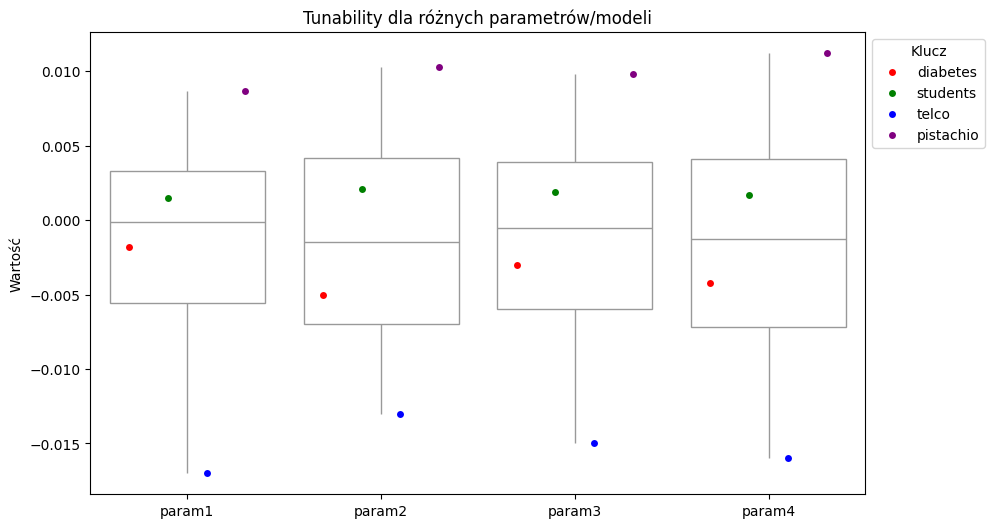

In [217]:
# tunability poszczególnych hiperparam
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def chart_2(parametry,wartosci):
    # Przykładowe dane:
    # parametry = ['param1', 'param2', 'param3', 'param4'], parametry to mogą być nazwy modeli wyjdzie na to samo
    # wartosci = [
    #     {'diabetes': -0.0018, 'students': 0.0015, 'telco': -0.017, 'pistachio': 0.0087},
    #     {'diabetes': -0.005, 'students': 0.0021, 'telco': -0.013, 'pistachio': 0.0103},
    #     {'diabetes': -0.003, 'students': 0.0019, 'telco': -0.015, 'pistachio': 0.0098},
    #     {'diabetes': -0.0042, 'students': 0.0017, 'telco': -0.016, 'pistachio': 0.0112}
    # ]

    # Przekształć dane na DataFrame
    dane = []
    for param, slownik in zip(parametry, wartosci):
        for klucz, wartosc in slownik.items():
            dane.append({'Parametr': param, 'Klucz': klucz, 'Wartość': wartosc})
    df = pd.DataFrame(dane)

    # Definiowanie kolorów dla kluczy
    kolory = {
        'diabetes': 'red',
        'students': 'green',
        'telco': 'blue',
        'pistachio': 'purple'
    }

    # Tworzenie wykresu
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Parametr', y='Wartość', data=df,color='white',showcaps = False) 
    sns.stripplot(
        x='Parametr', 
        y='Wartość', 
        hue='Klucz', 
        data=df, 
        palette=kolory, 
        dodge=True,  # Oddziel punkty dla różnych kluczy
        # jitter=True  # Rozproszenie punktów wzdłuż osi X dla lepszej widoczności,
    )
    plt.xlabel('')
    
    # Dostosowanie legendy
    plt.legend(title='Klucz', loc='upper left', bbox_to_anchor=(1, 1))
    plt.title('Tunability dla różnych parametrów/modeli')
    plt.show()

parametry = ['param1', 'param2', 'param3', 'param4']
wartosci = [
    {'diabetes': -0.0018, 'students': 0.0015, 'telco': -0.017, 'pistachio': 0.0087},
    {'diabetes': -0.005, 'students': 0.0021, 'telco': -0.013, 'pistachio': 0.0103},
    {'diabetes': -0.003, 'students': 0.0019, 'telco': -0.015, 'pistachio': 0.0098},
    {'diabetes': -0.0042, 'students': 0.0017, 'telco': -0.016, 'pistachio': 0.0112}
]
chart_2(parametry,wartosci)

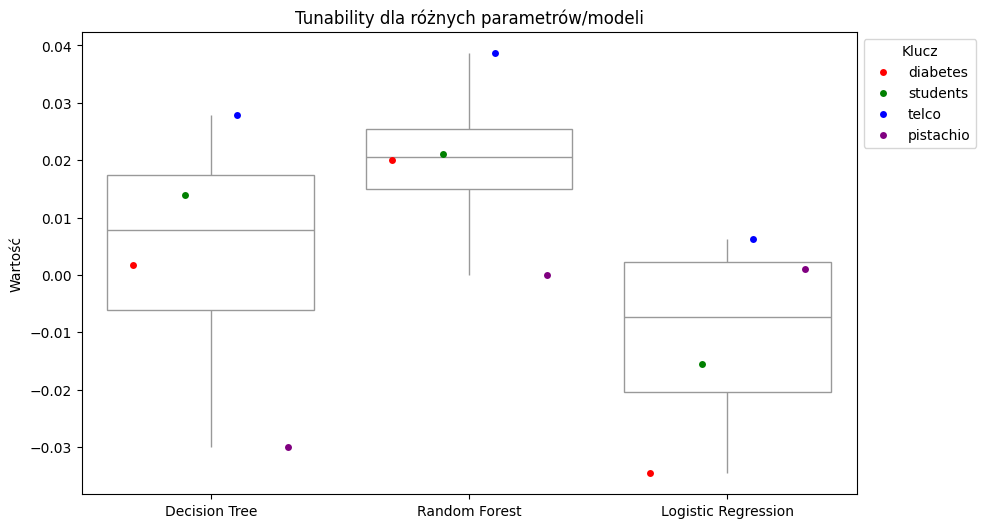

{'Decision Tree': {'diabetes': 0.0018181818181818299,
  'students': 0.013871374527112401,
  'telco': 0.027840909090909083,
  'pistachio': -0.02997819767441856},
 'Random Forest': {'diabetes': 0.020000000000000018,
  'students': 0.021017234131988194,
  'telco': 0.03863636363636358,
  'pistachio': 0.0},
 'Logistic Regression': {'diabetes': -0.03454545454545466,
  'students': -0.015552753257671359,
  'telco': 0.006249999999999978,
  'pistachio': 0.0009992732558139483}}

In [221]:
# # best_random_200iter_archive_v1
# best_random_history_200iter_archive_v1
# for key in best_random_history_params_200iter_archive_v1.keys():
#     for dataset in best_random_history_params_200iter_archive_v1[key].keys():
#         print(best_random_history_params_200iter_archive_v1[key][dataset][-1])
l1 = []
l2 = []
for key,val in tunability_random.items():
    l1.append(key)
    l2.append(val)
chart_2(l1,l2)
tunability_random

# Loswe punkty startowe ,a zbieżnosć BayesSearch

In [161]:
import numpy as np
from scipy.stats import uniform, randint
from skopt.space import Real

def sample_starting_points(param_space, n):
    """
    Losuje n punktów startowych na podstawie zadanej przestrzeni hiperparametrów.
    
    Args:
        param_space (dict): Słownik opisujący przestrzeń hiperparametrów. 
                            Wartości mogą być typu Real, Integer, lub lista.
        n (int): Liczba punktów startowych do wylosowania.
    
    Returns:
        list[dict]: Lista słowników z wylosowanymi punktami startowymi.
    """
    sampled_points = []
    
    for _ in range(n):
        point = {}
        for param, space in param_space.items():
            if isinstance(space, list):  # Dyskretna lista wartości
                point[param] = np.random.choice(space)
            elif isinstance(space, tuple) and hasattr(space[0], 'rvs'):  # np. Real/Integer
                point[param] = space[0].rvs(*space[1:])  # Losowanie z określonego rozkładu
            elif hasattr(space, 'rvs'):  # np. uniform lub inne rozkłady
                point[param] = space.rvs()
            else:
                raise ValueError(f"Nieobsługiwany typ przestrzeni dla {param}: {type(space)}")
        sampled_points.append(point)
    
    return sampled_points

param_space = { 
        'ccp_alpha': uniform(0, 1), 
        'max_depth': randint(1, 31),
        'min_samples_leaf': randint(1, 61),  
        'min_samples_split': randint(2, 61), 
    }

n = 5
print(sample_starting_points(param_space, n))


[{'ccp_alpha': 0.015917838064456125, 'max_depth': 27, 'min_samples_leaf': 16, 'min_samples_split': 18}, {'ccp_alpha': 0.5649007776968654, 'max_depth': 8, 'min_samples_leaf': 34, 'min_samples_split': 29}, {'ccp_alpha': 0.4690096891449652, 'max_depth': 4, 'min_samples_leaf': 54, 'min_samples_split': 27}, {'ccp_alpha': 0.47313576649888966, 'max_depth': 21, 'min_samples_leaf': 9, 'min_samples_split': 55}, {'ccp_alpha': 0.8106835727518807, 'max_depth': 6, 'min_samples_leaf': 58, 'min_samples_split': 59}]
